# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [33]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

In [34]:
import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta

ticker = "ETH/USD"
time_diff = datetime.now() - relativedelta(days=200)

# Alpaca Market Data Client
data_client = CryptoHistoricalDataClient()

# Defining Bar data request parameters
request_params = CryptoBarsRequest(
    symbol_or_symbols=[ticker],
    timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
    start=time_diff
)

# Get the bar data from Alpaca
signals_df = data_client.get_crypto_bars(request_params).df

# drop symbol multi-index
signals_df.reset_index(level='symbol', inplace=True)

In [35]:
signals_df.drop("symbol", axis=1, inplace=True)

# save copy
signals_df.to_csv("./ETH_time_series.csv", index="timestamp")

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-02-22 23:35:00+00:00,1640.8700,1641.450,1639.0900,1639.5300,178.54682,243.0,1640.263876
2023-02-22 23:40:00+00:00,1639.8000,1641.310,1639.8000,1641.1000,92.21355,156.0,1640.655342
2023-02-22 23:45:00+00:00,1641.0800,1642.890,1639.9100,1642.3600,112.91717,178.0,1641.192538
2023-02-22 23:50:00+00:00,1642.5700,1644.490,1642.0900,1644.1100,158.80281,213.0,1643.354328
2023-02-22 23:55:00+00:00,1644.0700,1644.770,1643.0100,1643.3200,119.97146,188.0,1643.934752
...,...,...,...,...,...,...,...
2023-09-11 04:10:00+00:00,1608.8250,1608.955,1608.2440,1608.3000,0.00000,0.0,0.000000
2023-09-11 04:15:00+00:00,1607.9910,1607.991,1607.5355,1607.5355,0.00000,0.0,0.000000
2023-09-11 04:20:00+00:00,1608.5885,1609.860,1608.5885,1609.8600,0.00000,0.0,0.000000


### Download stock time-series data from Alpaca API into Pandas DataFrame

In [3]:
# # THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# # API credentials
# API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
# SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# API_BASE_URL = "https://paper-api.alpaca.markets"

# # Create a connection to the API 
# api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# # Set the ticket symbol and the number of shares to buy
# ticker = "SPY"

# # Make API call
# signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2023-08-30", adjustment='raw').df

# # # Save the DataFrame with the date index
# # signals_df.to_csv('SPY_time_series_df.csv')

# # create a seperate dataframe for signals
# signals_df

### Read in stock time-series data from .csv file into Pandas DataFrame

In [4]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # save copy
# signals_df.to_csv("../data/SPY_time_series.csv", index="timestamp")

signals_df

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2023-02-22 23:10:00+00:00,ETH/USD,1643.3800,1645.0000,1642.6800,1643.1600,379.13581,389.0,1643.611271
2023-02-22 23:15:00+00:00,ETH/USD,1643.0000,1645.5900,1641.4200,1642.2100,629.89974,480.0,1643.842292
2023-02-22 23:20:00+00:00,ETH/USD,1642.5100,1642.9100,1639.6100,1640.4000,297.07849,335.0,1641.375690
2023-02-22 23:25:00+00:00,ETH/USD,1640.5400,1644.2400,1640.4900,1643.3600,149.04339,215.0,1642.715570
2023-02-22 23:30:00+00:00,ETH/USD,1643.6300,1643.6300,1640.1000,1640.6700,317.64240,314.0,1641.650379
...,...,...,...,...,...,...,...,...
2023-09-11 03:45:00+00:00,ETH/USD,1612.1385,1612.7855,1612.1385,1612.4150,0.00000,0.0,0.000000
2023-09-11 03:50:00+00:00,ETH/USD,1611.5850,1611.9750,1611.5850,1611.8655,0.00000,0.0,0.000000
2023-09-11 03:55:00+00:00,ETH/USD,1611.2500,1611.8000,1611.2500,1611.8000,0.00000,0.0,0.000000


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

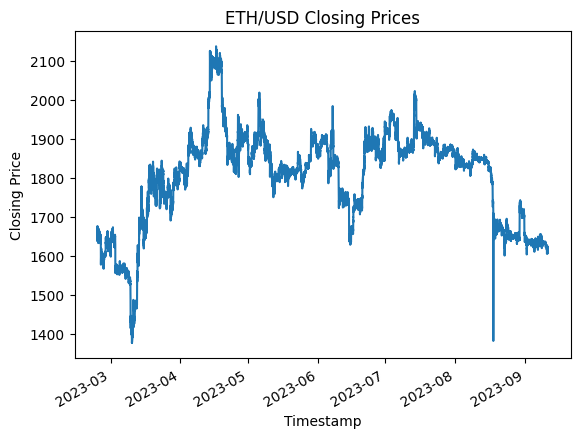

In [5]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [14]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns=["SIGNAL", "BB_MIDDLE"], inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,
2023-02-22 23:10:00+00:00,1643.3800,1645.0000,1642.6800,1643.1600,379.13581,389.0,1643.611271,1643.160000,1643.160000,1643.160000,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2023-02-22 23:15:00+00:00,1643.0000,1645.5900,1641.4200,1642.2100,629.89974,480.0,1643.842292,1642.632222,1642.661250,1642.675500,NaN,NaN,0.000000,NaN,NaN,-0.021314,0,0
2023-02-22 23:20:00+00:00,1642.5100,1642.9100,1639.6100,1640.4000,297.07849,335.0,1641.375690,1641.717377,1641.830933,1641.886462,NaN,NaN,0.000000,NaN,NaN,-0.083286,0,0
2023-02-22 23:25:00+00:00,1640.5400,1644.2400,1640.4900,1643.3600,149.04339,215.0,1642.715570,1642.273821,1642.272351,1642.277238,NaN,NaN,54.213974,NaN,NaN,-0.002562,0,0
2023-02-22 23:30:00+00:00,1643.6300,1643.6300,1640.1000,1640.6700,317.64240,314.0,1641.650379,1641.796721,1641.884756,1641.929571,NaN,NaN,35.420384,NaN,NaN,-0.065685,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 03:45:00+00:00,1612.1385,1612.7855,1612.1385,1612.4150,0.00000,0.0,0.000000,1612.141533,1611.623063,1612.340799,1616.952310,0.910786,54.565419,1614.111333,1608.656767,0.378253,0,0
2023-09-11 03:50:00+00:00,1611.5850,1611.9750,1611.5850,1611.8655,0.00000,0.0,0.000000,1612.086326,1611.646153,1612.322160,1616.896413,0.920429,51.409647,1613.781950,1609.377200,0.342223,0,0
2023-09-11 03:55:00+00:00,1611.2500,1611.8000,1611.2500,1611.8000,0.00000,0.0,0.000000,1612.029061,1611.660805,1612.301683,1616.836358,0.859786,51.030787,1613.591792,1609.833558,0.304869,0,0


In [7]:
# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # Review DataFrame
# signals_df

### Create Volatility Based Targets and Stops

In [15]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 1
risk = 1

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df.iloc[j, -2] = stop
            signals_df.iloc[j, -1] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df.iloc[j, -2] = target
            signals_df.iloc[j, -1] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_17292\3916546166.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1649.293482142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df.iloc[j, -2] = stop


,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,
2023-02-23 15:50:00+00:00,1654.3400,1656.4000,1652.8900,1655.9900,425.583510,599.0,1654.835288,1656.982997,1657.403908,1656.988104,1658.422550,6.696518,48.440369,1669.192563,1648.751437,-0.087983,1649.293482,-1
2023-02-23 15:55:00+00:00,1656.2500,1656.2700,1653.5000,1655.8400,388.527660,597.0,1655.251242,1656.754398,1657.254964,1656.943066,1658.490700,6.010089,48.262608,1667.270220,1649.297780,-0.189891,1649.829911,-1
2023-02-23 16:00:00+00:00,1655.7900,1659.8400,1655.2600,1658.2500,585.308447,704.0,1657.514963,1657.053518,1657.349730,1656.994334,1658.579950,6.063661,51.351540,1666.283019,1649.576981,-0.075319,1652.186339,-1
2023-02-23 16:05:00+00:00,1658.0000,1658.0000,1651.2900,1652.7700,463.091790,756.0,1653.928405,1656.196815,1656.913565,1656.828626,1658.627000,6.262232,44.801491,1665.147991,1649.441009,-0.421847,1659.032232,1
2023-02-23 16:10:00+00:00,1653.0400,1656.0100,1652.0200,1653.1700,359.583890,470.0,1654.151562,1655.591452,1656.557035,1656.685111,1658.689500,5.902946,45.349452,1664.113506,1649.382494,-0.656628,1647.267054,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 03:45:00+00:00,1612.1385,1612.7855,1612.1385,1612.4150,0.000000,0.0,0.000000,1612.141533,1611.623063,1612.340799,1616.952310,0.910786,54.565419,1614.111333,1608.656767,0.378253,1611.504214,-1
2023-09-11 03:50:00+00:00,1611.5850,1611.9750,1611.5850,1611.8655,0.000000,0.0,0.000000,1612.086326,1611.646153,1612.322160,1616.896413,0.920429,51.409647,1613.781950,1609.377200,0.342223,1610.945071,-1
2023-09-11 03:55:00+00:00,1611.2500,1611.8000,1611.2500,1611.8000,0.000000,0.0,0.000000,1612.029061,1611.660805,1612.301683,1616.836358,0.859786,51.030787,1613.591792,1609.833558,0.304869,1610.940214,-1


### Data Cleaning

In [18]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# # include only higher than 1 volume
signals_df = signals_df.loc[signals_df["volume"] != 0]

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,
2023-02-23 15:50:00+00:00,1654.3400,1656.4000,1652.890,1655.9900,425.583510,599.0,1654.835288,1656.982997,1657.403908,1656.988104,1658.422550,6.696518,48.440369,1669.192563,1648.751437,-0.087983,1649.293482,-1
2023-02-23 15:55:00+00:00,1656.2500,1656.2700,1653.500,1655.8400,388.527660,597.0,1655.251242,1656.754398,1657.254964,1656.943066,1658.490700,6.010089,48.262608,1667.270220,1649.297780,-0.189891,1649.829911,-1
2023-02-23 16:00:00+00:00,1655.7900,1659.8400,1655.260,1658.2500,585.308447,704.0,1657.514963,1657.053518,1657.349730,1656.994334,1658.579950,6.063661,51.351540,1666.283019,1649.576981,-0.075319,1652.186339,-1
2023-02-23 16:05:00+00:00,1658.0000,1658.0000,1651.290,1652.7700,463.091790,756.0,1653.928405,1656.196815,1656.913565,1656.828626,1658.627000,6.262232,44.801491,1665.147991,1649.441009,-0.421847,1659.032232,1
2023-02-23 16:10:00+00:00,1653.0400,1656.0100,1652.020,1653.1700,359.583890,470.0,1654.151562,1655.591452,1656.557035,1656.685111,1658.689500,5.902946,45.349452,1664.113506,1649.382494,-0.656628,1647.267054,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 18:25:00+00:00,1613.7010,1613.7010,1612.356,1613.1485,0.338568,1.0,1613.701000,1611.017690,1610.755582,1613.972433,1623.024675,1.948929,55.128762,1614.114981,1603.718119,-0.635222,1611.199571,-1
2023-09-10 19:25:00+00:00,1611.2970,1611.8200,1610.050,1610.3375,0.061578,2.0,1611.789512,1611.263233,1611.271975,1613.070436,1621.944300,1.243214,44.295034,1614.487270,1607.998480,-0.163812,1609.094286,-1
2023-09-10 20:35:00+00:00,1619.4900,1619.4900,1617.261,1618.5000,0.010972,1.0,1617.261000,1618.674981,1616.113019,1614.662051,1620.943900,3.727786,57.289435,1624.323068,1604.948982,2.468513,1622.227786,1


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

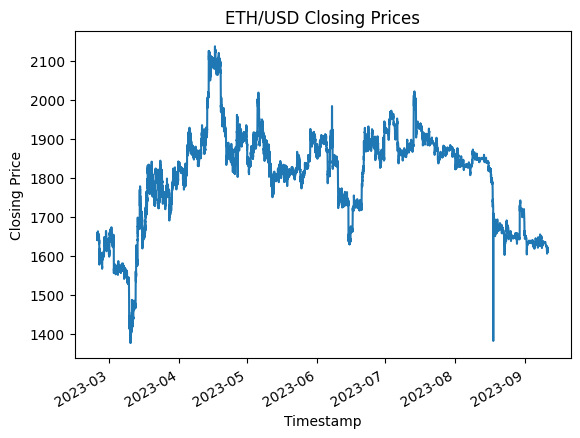

In [19]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

In [31]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=3))

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,
2023-02-23 15:50:00+00:00,1654.3400,1656.4000,1652.890,1655.9900,425.583510,599.0,1654.835288,1656.982997,1657.403908,1656.988104,1658.422550,6.696518,48.440369,1669.192563,1648.751437,-0.087983,1649.293482,-1
2023-02-23 15:55:00+00:00,1656.2500,1656.2700,1653.500,1655.8400,388.527660,597.0,1655.251242,1656.754398,1657.254964,1656.943066,1658.490700,6.010089,48.262608,1667.270220,1649.297780,-0.189891,1649.829911,-1
2023-02-23 16:00:00+00:00,1655.7900,1659.8400,1655.260,1658.2500,585.308447,704.0,1657.514963,1657.053518,1657.349730,1656.994334,1658.579950,6.063661,51.351540,1666.283019,1649.576981,-0.075319,1652.186339,-1
2023-02-23 16:05:00+00:00,1658.0000,1658.0000,1651.290,1652.7700,463.091790,756.0,1653.928405,1656.196815,1656.913565,1656.828626,1658.627000,6.262232,44.801491,1665.147991,1649.441009,-0.421847,1659.032232,1
2023-02-23 16:10:00+00:00,1653.0400,1656.0100,1652.020,1653.1700,359.583890,470.0,1654.151562,1655.591452,1656.557035,1656.685111,1658.689500,5.902946,45.349452,1664.113506,1649.382494,-0.656628,1647.267054,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 18:25:00+00:00,1613.7010,1613.7010,1612.356,1613.1485,0.338568,1.0,1613.701000,1611.017690,1610.755582,1613.972433,1623.024675,1.948929,55.128762,1614.114981,1603.718119,-0.635222,1611.199571,-1
2023-09-10 19:25:00+00:00,1611.2970,1611.8200,1610.050,1610.3375,0.061578,2.0,1611.789512,1611.263233,1611.271975,1613.070436,1621.944300,1.243214,44.295034,1614.487270,1607.998480,-0.163812,1609.094286,-1
2023-09-10 20:35:00+00:00,1619.4900,1619.4900,1617.261,1618.5000,0.010972,1.0,1617.261000,1618.674981,1616.113019,1614.662051,1620.943900,3.727786,57.289435,1624.323068,1604.948982,2.468513,1622.227786,1


In [32]:
signals_df.to_csv("ETH_time_series.csv", index_label="timestamp")

### Split the data into training and testing sets.

In [21]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

timestamp
2023-02-23 15:50:00+00:00   -1
2023-02-23 15:55:00+00:00   -1
2023-02-23 16:00:00+00:00   -1
2023-02-23 16:05:00+00:00    1
2023-02-23 16:10:00+00:00   -1
Name: Exit, dtype: int64

In [22]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [23]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [25]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'ETH_5MIN_10TO10_SVM.pkl')

In [ ]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

In [26]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.55      0.59      0.57     12696
           1       0.56      0.51      0.53     12696

    accuracy                           0.55     25392
   macro avg       0.55      0.55      0.55     25392
weighted avg       0.55      0.55      0.55     25392



In [27]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [28]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

          -1       0.48      0.54      0.51      4612
           1       0.55      0.49      0.52      5257

    accuracy                           0.51      9869
   macro avg       0.51      0.51      0.51      9869
weighted avg       0.52      0.51      0.51      9869



### Visualization

In [29]:
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


predictions_df["trading_algorithm_returns"] = (
    predictions_df["algo_returns"] * predictions_df["predicted_signal"]
)

predictions_df = predictions_df.drop(columns=["algo_returns"])

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

# Filter rows where the predicted signal is 1 and the probability estimate is >= 0.60
buy_signals_df = predictions_df[(predictions_df["predicted_signal"] == 1) & (predictions_df["probability_estimates"] >= 0.50)]


### Evaluation Metrics

In [30]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


Risk:Reward Ratio: 1.0
Win Rate (%): 54.714981987709265
Profit Factor: 1.5155653500743234
Sortino Ratio: -0.10416055818746427
Average Profit per Winning Trade (%): 0.3095638524138372
Average Loss per Losing Trade (%): -0.24678984820649827
Average Return (%): 0.05761897887587217
Trade Frequency (Trades per Day): 42.513513513513516
Downside Deviation: 0.18647951344772012
Volatility (Standard Deviation of Algo Returns): 0.003505231351589949
Gross Profit (%): 799.2938669325276
Gross Loss (%): -527.3899056172868
Total Number of Winning Trades: 2582
Total Number of Trades: 4719
Risk-Free Rate (%): 2.0


### WIP METRICS

In [ ]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


In [ ]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
buy_signals_df

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


In [ ]:
# Calculate Kelly Criterion
kelly_criterion = (win_rate * (average_profit_per_winning_trade / abs(average_loss_per_losing_trade))) - ((1 - win_rate) / abs(average_loss_per_losing_trade))

# Calculate Sharpe Ratio (assuming a risk-free rate has already been defined)
sharpe_ratio = (average_return - risk_free_rate) / algo_volatility

# # Calculate Calmar Ratio
# calmar_ratio = (average_return - risk_free_rate) / (drawdown_max / 100)

# Calculate Pain/Gain Ratio
pain_gain_ratio = (average_loss_per_losing_trade * win_rate) / (average_profit_per_winning_trade * (1 - win_rate))

print(kelly_criterion, sharpe_ratio, pain_gain_ratio)

In [ ]:
import pandas as pd

df2 = pd.DataFrame([{'Risk': 1, 'Reward': 1, 'Win Rate (%)': 51.68067226890757, 'Profit Factor': 1.0733808813416092, 'Cumulative Returns': 1.6981633887097984, 'Sortino Ratio': -0.14363021901285425, 'Average Profit per Winning Trade (%)': 0.19316427176882509, 'Average Loss per Losing Trade (%)': -0.192477609689141, 'Average Return (%)': 0.006824707198799467, 'Trade Frequency (Trades per Day)': 19.4052757793765, 'Downside Deviation': 0.1387713049872061, 'Volatility (Standard Deviation of Algo Returns)': 0.002368281480211426, 'Gross Profit (%)': 807.8129845372265, 'Gross Loss (%)': -752.5874538845412, 'Total Number of Winning Trades': 4182, 'Total Number of Trades': 8092, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 1, 'Reward': 2, 'Win Rate (%)': 35.77304621340431, 'Profit Factor': 1.05958611909491, 'Cumulative Returns': 1.7267841361193652, 'Sortino Ratio': -0.1520338826163541, 'Average Profit per Winning Trade (%)': 0.35362932527676333, 'Average Loss per Losing Trade (%)': -0.1858876817721641, 'Average Return (%)': 0.007113986488624433, 'Trade Frequency (Trades per Day)': 19.587677725118482, 'Downside Deviation': 0.13108170226371654, 'Volatility (Standard Deviation of Algo Returns)': 0.0031827184215105254, 'Gross Profit (%)': 1045.681914843389, 'Gross Loss (%)': -986.8777025284193, 'Total Number of Winning Trades': 2957, 'Total Number of Trades': 8266, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 1, 'Reward': 3, 'Win Rate (%)': 27.78675282714055, 'Profit Factor': 1.100286720777277, 'Cumulative Returns': 2.752065555429843, 'Sortino Ratio': -0.14672493598180517, 'Average Profit per Winning Trade (%)': 0.5733131099406654, 'Average Loss per Losing Trade (%)': -0.20049655975417627, 'Average Return (%)': 0.014520020516442102, 'Trade Frequency (Trades per Day)': 17.601895734597157, 'Downside Deviation': 0.13531987362596432, 'Volatility (Standard Deviation of Algo Returns)': 0.004230218052636733, 'Gross Profit (%)': 1183.3182589175333, 'Gross Loss (%)': -1075.4635465214014, 'Total Number of Winning Trades': 2064, 'Total Number of Trades': 7428, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 3.0}, {'Risk': 1, 'Reward': 4, 'Win Rate (%)': 22.463641142456634, 'Profit Factor': 1.146807347147665, 'Cumulative Returns': 9.129773001813188, 'Sortino Ratio': -0.1595430374572503, 'Average Profit per Winning Trade (%)': 0.7098245687907394, 'Average Loss per Losing Trade (%)': -0.17932271714677295, 'Average Return (%)': 0.020412138394122568, 'Trade Frequency (Trades per Day)': 27.11163895486936, 'Downside Deviation': 0.12407861183765603, 'Volatility (Standard Deviation of Algo Returns)': 0.0045651670230988425, 'Gross Profit (%)': 1819.9901943794557, 'Gross Loss (%)': -1587.0060467489407, 'Total Number of Winning Trades': 2564, 'Total Number of Trades': 11414, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 4.0}, {'Risk': 1, 'Reward': 5, 'Win Rate (%)': 18.91391794046661, 'Profit Factor': 1.1842010602338142, 'Cumulative Returns': 19.21339421429835, 'Sortino Ratio': -0.17483071153284377, 'Average Profit per Winning Trade (%)': 0.8478347760969701, 'Average Loss per Losing Trade (%)': -0.16700172789727055, 'Average Return (%)': 0.0249436156981003, 'Trade Frequency (Trades per Day)': 29.879807692307693, 'Downside Deviation': 0.11296964743696446, 'Volatility (Standard Deviation of Algo Returns)': 0.004843899143568176, 'Gross Profit (%)': 1993.2595586039768, 'Gross Loss (%)': -1683.21041547659, 'Total Number of Winning Trades': 2351, 'Total Number of Trades': 12430, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 5.0}, {'Risk': 1, 'Reward': 6, 'Win Rate (%)': 15.983054111303677, 'Profit Factor': 1.1266067235604857, 'Cumulative Returns': 6.110771001826533, 'Sortino Ratio': -0.1688073791475524, 'Average Profit per Winning Trade (%)': 1.0516066737430287, 'Average Loss per Losing Trade (%)': -0.17757174977204826, 'Average Return (%)': 0.01888850278283601, 'Trade Frequency (Trades per Day)': 24.906474820143885, 'Downside Deviation': 0.11735929479039536, 'Volatility (Standard Deviation of Algo Returns)': 0.005431757528649323, 'Gross Profit (%)': 1745.6670784134278, 'Gross Loss (%)': -1549.491088510893, 'Total Number of Winning Trades': 1660, 'Total Number of Trades': 10386, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 6.0}, {'Risk': 1, 'Reward': 7, 'Win Rate (%)': 13.468958260259559, 'Profit Factor': 1.117209629262293, 'Cumulative Returns': 6.74488962748203, 'Sortino Ratio': -0.16794699002800184, 'Average Profit per Winning Trade (%)': 1.3153326431011594, 'Average Loss per Losing Trade (%)': -0.18325802547982284, 'Average Return (%)': 0.018586526163494318, 'Trade Frequency (Trades per Day)': 27.814634146341465, 'Downside Deviation': 0.11797850461661409, 'Volatility (Standard Deviation of Algo Returns)': 0.006119342420482885, 'Gross Profit (%)': 2020.350939803381, 'Gross Loss (%)': -1808.3901954348917, 'Total Number of Winning Trades': 1536, 'Total Number of Trades': 11404, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 7.0}, {'Risk': 1, 'Reward': 8, 'Win Rate (%)': 11.29889859475883, 'Profit Factor': 1.0211034557736671, 'Cumulative Returns': 1.1681295019708415, 'Sortino Ratio': -0.18094208414035765, 'Average Profit per Winning Trade (%)': 1.2859914590404409, 'Average Loss per Losing Trade (%)': -0.1604262517614647, 'Average Return (%)': 0.0030030186386746766, 'Trade Frequency (Trades per Day)': 25.37831325301205, 'Downside Deviation': 0.11036663973717939, 'Volatility (Standard Deviation of Algo Returns)': 0.0055682311396454435, 'Gross Profit (%)': 1530.3298362581245, 'Gross Loss (%)': -1498.702043955603, 'Total Number of Winning Trades': 1190, 'Total Number of Trades': 10532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 8.0}, {'Risk': 1, 'Reward': 9, 'Win Rate (%)': 9.97675319643549, 'Profit Factor': 1.0421426081700698, 'Cumulative Returns': 1.5578357787092199, 'Sortino Ratio': -0.18190396489322677, 'Average Profit per Winning Trade (%)': 1.5257217293710597, 'Average Loss per Losing Trade (%)': -0.16224926407266865, 'Average Return (%)': 0.0061554359706324, 'Trade Frequency (Trades per Day)': 25.180487804878048, 'Downside Deviation': 0.10960973639028188, 'Volatility (Standard Deviation of Algo Returns)': 0.0061560588273859105, 'Gross Profit (%)': 1571.4933812521913, 'Gross Loss (%)': -1507.9446602913827, 'Total Number of Winning Trades': 1030, 'Total Number of Trades': 10324, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 9.0}, {'Risk': 1, 'Reward': 10, 'Win Rate (%)': 9.25785527756718, 'Profit Factor': 1.1177128345711183, 'Cumulative Returns': 6.923804356871475, 'Sortino Ratio': -0.16977017227231853, 'Average Profit per Winning Trade (%)': 1.9421598768013533, 'Average Loss per Losing Trade (%)': -0.17727850781623858, 'Average Return (%)': 0.018936030528865725, 'Trade Frequency (Trades per Day)': 28.604819277108433, 'Downside Deviation': 0.1166909323914347, 'Volatility (Standard Deviation of Algo Returns)': 0.007335378575907445, 'Gross Profit (%)': 2134.4337046046876, 'Gross Loss (%)': -1909.644086196522, 'Total Number of Winning Trades': 1099, 'Total Number of Trades': 11871, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 10.0}, {'Risk': 2, 'Reward': 1, 'Win Rate (%)': 68.69128249945379, 'Profit Factor': 1.1209493771506291, 'Cumulative Returns': 4.019103059638137, 'Sortino Ratio': -0.07157980981951251, 'Average Profit per Winning Trade (%)': 0.21330034380778626, 'Average Loss per Losing Trade (%)': -0.41748598657170116, 'Average Return (%)': 0.015809233597210474, 'Trade Frequency (Trades per Day)': 21.691943127962084, 'Downside Deviation': 0.2771997818108065, 'Volatility (Standard Deviation of Algo Returns)': 0.0034939938262840238, 'Gross Profit (%)': 1341.23256186336, 'Gross Loss (%)': -1196.5148375144954, 'Total Number of Winning Trades': 6288, 'Total Number of Trades': 9154, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.5}, {'Risk': 2, 'Reward': 2, 'Win Rate (%)': 53.1588132635253, 'Profit Factor': 1.1237644260201742, 'Cumulative Returns': 6.983067343491182, 'Sortino Ratio': -0.07510792652208369, 'Average Profit per Winning Trade (%)': 0.40639253140459364, 'Average Loss per Losing Trade (%)': -0.4104098973417249, 'Average Return (%)': 0.023792580487469902, 'Trade Frequency (Trades per Day)': 20.36729857819905, 'Downside Deviation': 0.26311569377853533, 'Volatility (Standard Deviation of Algo Returns)': 0.0048546199762111554, 'Gross Profit (%)': 1856.8074759875885, 'Gross Loss (%)': -1652.3102466977846, 'Total Number of Winning Trades': 4569, 'Total Number of Trades': 8595, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 2, 'Reward': 3, 'Win Rate (%)': 45.64673789497613, 'Profit Factor': 1.2469617844590983, 'Cumulative Returns': 119.99483207787554, 'Sortino Ratio': -0.0739975404278595, 'Average Profit per Winning Trade (%)': 0.6231401001186321, 'Average Loss per Losing Trade (%)': -0.41967846829690003, 'Average Return (%)': 0.05633419034788029, 'Trade Frequency (Trades per Day)': 21.098321342925658, 'Downside Deviation': 0.26266627220495353, 'Volatility (Standard Deviation of Algo Returns)': 0.006179535779189895, 'Gross Profit (%)': 2502.530642076427, 'Gross Loss (%)': -2006.9024353957757, 'Total Number of Winning Trades': 4016, 'Total Number of Trades': 8798, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.5}])

df2

In [ ]:
df3 = pd.DataFrame([{'Risk': 3, 'Reward': 1, 'Win Rate (%)': 77.8505182760502, 'Profit Factor': 1.203715570032061, 'Cumulative Returns': 11.822006597759954, 'Sortino Ratio': -0.046839253796216444, 'Average Profit per Winning Trade (%)': 0.21113395363415885, 'Average Loss per Losing Trade (%)': -0.6164986666336241, 'Average Return (%)': 0.027817617666499383, 'Trade Frequency (Trades per Day)': 21.718009478672986, 'Downside Deviation': 0.42105333080537005, 'Volatility (Standard Deviation of Algo Returns)': 0.004146650940829134, 'Gross Profit (%)': 1506.4407591797237, 'Gross Loss (%)': -1251.4922932662569, 'Total Number of Winning Trades': 7135, 'Total Number of Trades': 9165, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.3333333333333333}, {'Risk': 3, 'Reward': 2, 'Win Rate (%)': 64.60946094609461, 'Profit Factor': 1.2172272320864916, 'Cumulative Returns': 51.20511169670716, 'Sortino Ratio': -0.04989418874686769, 'Average Profit per Winning Trade (%)': 0.3892823938383657, 'Average Loss per Losing Trade (%)': -0.5838510186193874, 'Average Return (%)': 0.04488523345590238, 'Trade Frequency (Trades per Day)': 21.540284360189574, 'Downside Deviation': 0.3918522007569144, 'Volatility (Standard Deviation of Algo Returns)': 0.0056104785174589675, 'Gross Profit (%)': 2286.255499012722, 'Gross Loss (%)': -1878.248726898569, 'Total Number of Winning Trades': 5873, 'Total Number of Trades': 9090, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.6666666666666666}, {'Risk': 3, 'Reward': 3, 'Win Rate (%)': 56.55839325564096, 'Profit Factor': 1.333831872648241, 'Cumulative Returns': 1216.990605482476, 'Sortino Ratio': -0.04846491342330071, 'Average Profit per Winning Trade (%)': 0.6420604356339619, 'Average Loss per Losing Trade (%)': -0.6267091011696977, 'Average Return (%)': 0.09088656296349037, 'Trade Frequency (Trades per Day)': 19.113744075829384, 'Downside Deviation': 0.3939166093957481, 'Volatility (Standard Deviation of Algo Returns)': 0.007448328661882918, 'Gross Profit (%)': 2929.079707362134, 'Gross Loss (%)': -2195.9886904986206, 'Total Number of Winning Trades': 4562, 'Total Number of Trades': 8066, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 3, 'Reward': 4, 'Win Rate (%)': 48.9613496160141, 'Profit Factor': 1.3303253870544738, 'Cumulative Returns': 3717.433244592763, 'Sortino Ratio': -0.04866670406301193, 'Average Profit per Winning Trade (%)': 0.884383350686972, 'Average Loss per Losing Trade (%)': -0.6377300445725529, 'Average Return (%)': 0.10751721643264571, 'Trade Frequency (Trades per Day)': 18.822274881516588, 'Downside Deviation': 0.3888660265788771, 'Volatility (Standard Deviation of Algo Returns)': 0.008919371326135978, 'Gross Profit (%)': 3439.366850821634, 'Gross Loss (%)': -2585.3576006971293, 'Total Number of Winning Trades': 3889, 'Total Number of Trades': 7943, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.3333333333333333}, {'Risk': 3, 'Reward': 5, 'Win Rate (%)': 44.91377155711072, 'Profit Factor': 1.3851483858603222, 'Cumulative Returns': 38468.73154278567, 'Sortino Ratio': -0.04836356807753073, 'Average Profit per Winning Trade (%)': 1.0984235144350671, 'Average Loss per Losing Trade (%)': -0.646561749333405, 'Average Return (%)': 0.1371769457408125, 'Trade Frequency (Trades per Day)': 18.96208530805687, 'Downside Deviation': 0.38517072422632903, 'Volatility (Standard Deviation of Algo Returns)': 0.010178804899092724, 'Gross Profit (%)': 3947.7341108796318, 'Gross Loss (%)': -2850.0441910616496, 'Total Number of Winning Trades': 3594, 'Total Number of Trades': 8002, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.6666666666666667}, {'Risk': 3, 'Reward': 6, 'Win Rate (%)': 41.127008032128515, 'Profit Factor': 1.4170141785150603, 'Cumulative Returns': 27413.417870999685, 'Sortino Ratio': -0.05254655287481603, 'Average Profit per Winning Trade (%)': 1.1002004119457576, 'Average Loss per Losing Trade (%)': -0.5423861808794576, 'Average Return (%)': 0.13316053908643477, 'Trade Frequency (Trades per Day)': 18.881516587677726, 'Downside Deviation': 0.35527344017428114, 'Volatility (Standard Deviation of Algo Returns)': 0.009869561208901546, 'Gross Profit (%)': 3605.3567499462483, 'Gross Loss (%)': -2544.3335745055356, 'Total Number of Winning Trades': 3277, 'Total Number of Trades': 7968, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 3, 'Reward': 7, 'Win Rate (%)': 37.343206891340486, 'Profit Factor': 1.3798810967175241, 'Cumulative Returns': 7213.183702688102, 'Sortino Ratio': -0.0535015281039731, 'Average Profit per Winning Trade (%)': 1.3681541255325065, 'Average Loss per Losing Trade (%)': -0.5909310453320537, 'Average Return (%)': 0.1406541832014703, 'Trade Frequency (Trades per Day)': 16.139024390243904, 'Downside Deviation': 0.34753134773742134, 'Volatility (Standard Deviation of Algo Returns)': 0.01129157964340588, 'Gross Profit (%)': 3380.7088441908236, 'Gross Loss (%)': -2450.0001139466945, 'Total Number of Winning Trades': 2471, 'Total Number of Trades': 6617, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.3333333333333335}, {'Risk': 3, 'Reward': 8, 'Win Rate (%)': 34.21616656460502, 'Profit Factor': 1.4298196794618128, 'Cumulative Returns': 28121.319732757576, 'Sortino Ratio': -0.05182295559683708, 'Average Profit per Winning Trade (%)': 1.6004115072472562, 'Average Loss per Losing Trade (%)': -0.5821870875922998, 'Average Return (%)': 0.1646144830547314, 'Trade Frequency (Trades per Day)': 15.93170731707317, 'Downside Deviation': 0.3541645774169793, 'Volatility (Standard Deviation of Algo Returns)': 0.012460948831190762, 'Gross Profit (%)': 3576.919718697618, 'Gross Loss (%)': -2501.657915384112, 'Total Number of Winning Trades': 2235, 'Total Number of Trades': 6532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.6666666666666665}])

df3

In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()
